# Probing Experiments

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [2]:
import os
import jax
import pickle as pkl
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from typing import Dict, List
from matplotlib import cm, colors

from configs.config import get_experiment_config, get_model_config
from src.models.auxiliary_models import batched_chebyshev
from src.training_init import TrainingInitializer
from src.util.probings.probe_layers import ProbeLayers
from src.models.auxiliary_models import LeastSquaresSequenceSolver
from src.util.sequence_performance.sequenceloss_eval import SequencePredictionEvaluator
from src.models.auxiliary_models import learn_parameters_chebyshev

In [20]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.devices()

rerun_models = False
rerun_analyses = False
store_results = False
path_chebyshev = 'experiment_results/linear_seq_fully/cheb_params.pkl'

path_model_fully_7 = 'experiment_results/linear_seq_fully/model_sm_7l_fullfledged.pkl'
path_model_fully_3 = 'experiment_results/linear_seq_fully/model_sm_3l_fullfledged.pkl'
path_model_partobs_7 = 'experiment_results/linear_seq_partial/model_sm_7l_fullfledged.pkl'
path_model_nonlin_7 = 'experiment_results/nonlinear_seq_fully/model_sm_7l_fullfledged.pkl'

path_probing_fully = 'experiment_results/linear_seq_fully/probing_results_sm_7l.pkl'
path_probing_partobs = 'experiment_results/linear_seq_partial/probing_results_sm_7l.pkl'
path_probing_nonlin = 'experiment_results/nonlinear_seq_fully/probing_results_sm_7l.pkl'

path_seqperf_fully = 'experiment_results/linear_seq_fully/seqperf_results_sm_probing.pkl'
path_seqperf_partobs = 'experiment_results/linear_seq_partial/seqperf_results_sm_probing.pkl'
path_seqperf_nonlin = 'experiment_results/nonlinear_seq_fully/seqperf_results_sm_probing.pkl'

print(f'Running on Devices: {devices},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


**Define Models:**

<font color='grey'>Arguments for Model-Config, Seperated by '.':</font> <br>
    - model: Defines Model Type (fixed settings for all other fields). See config.py file for further information.<br>
    - layers: No. of layers in the Transformer. For certain model types (such as those used here), we have layers = 'True' model-layers - 1, as we add another special layer which incorporates the PE-logic in the attention. Thus, a six-layer model is actually seven layers deep. A layer comprises of the multi-head attention mechanism as well as potentially various types of (Layer-) Normalization mechanisms, MLPs and standard residual connections.<br>
    - heads: No. of attention heads.<br>
    - embed_dim: Dimension of embeddings used for computations in the Transformer. <br>
    - seq_len: Length of input sequence lengths.<br>
    - key_size: Key-size per head in attention. <br>
    - pe_kq: Use Positional encodings in keys/queries in special first layer instead of adding them to the residual stream.<br>
    - pe_emb: Use standard Positional encodings, added to the residual stream before the first Transformer layer. <br>
    - laynorm: Use standard Layer-Normalization in each Transformer layer.<br>
    - mlp: Use standard MLP in Transformer layers. Activation function is GeLu (jax.nn.gelu).<br>
    - dim_mlp: Dimension of hidden MLP layers.<br>
    - linear: Use linear self-attention.<br>
    - clip: Use forward-pass activation clipping (of the residual stream).<br>
    - clip_val: Clipping bandwidth (i.e. x <- Clip(x, min=-clip_val, max=clip_val)). <br>
    - schlagnorm: Use 'Schlag-Normalization' as proposed by Schlag, 2021: Separate Normalization of query and key projections in the attention-mechanism.<br>
    - schlagnorm_t: Also normalize value projections.<br>
    - schlagnorm_hyb: Use Schlag-Norm in the first layer.<br>
    - schlagnorm_t_hyb: Also normalize value projections in the first layer.<br>

In [6]:
models = {'full_seven_sm':      'fully_obs_full_fledged_transformer.6.4.40.50.20.True.False.False.False.0.False.False.0.False.False.False.False',
          'full_three_sm':      'fully_obs_full_fledged_transformer.2.4.40.50.20.True.False.False.False.0.False.False.0.False.False.False.False',
          'full_mesa':          'fully_obs_full_fledged_mesa.1.4.40.50.20.True.False.False.False.0.False.True.1.False.False.False.False',
          'just_mesa':          'just_mesa.1.4.40.50.20.True.False.False.False.0.False.True.1.False.False.False.False',
          'partobs_seven_sm':   'part_obs_full_fledged_transformer.6.12.80.50.20.True.False.False.False.0.False.False.0.False.False.False.False',
          'partobs_mesa':       'part_obs_full_fledged_mesa.1.12.80.50.20.True.False.False.False.0.False.True.1.False.False.False.False',
          'nonlin_seven_sm':    'nonlinear_full_fledged_transformer.6.4.60.50.20.True.False.False.True.300.False.False.0.True.False.False.False',
          'nonlin_mesa':        'fully_obs_full_fledged_mesa.1.4.60.50.20.True.False.False.True.300.False.True.15.True.False.False.False'}

## Training models:

### Training on fully observable linear dynamical systems:

In [10]:
exp_config_probing_fully = get_experiment_config(experiment='probing_full', seeds=[1, 11, 111, 1111, 11111])
(model_f7, optimizer_f7, data_generator_f7, train_module_f7) = TrainingInitializer(model_config=get_model_config(models['full_seven_sm']), 
                                                                                   experiment_config=exp_config_probing_fully).run()
(model_f3, optimizer_f3, data_generator_f3, train_module_f3) = TrainingInitializer(model_config=get_model_config(models['full_three_sm']), 
                                                                                   experiment_config=exp_config_probing_fully).run()
training_seed = 11111
rng = jax.random.PRNGKey(training_seed)
rng, test_rng, train_rng = jax.random.split(rng, 3)
if rerun_models:
    state_tf_fully_7, rng = train_module_f7.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(100):
        state_tf_fully_7, train_rng, _, _, _ = train_module_f7.train_epoch(epoch=epoch_idx,
                                                                           state=state_tf_fully_7,
                                                                           rng=train_rng,
                                                                           test_rng=test_rng,
                                                                           num_batches_train=100,
                                                                           interpolate=False)
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_fully_3, rng = train_module_f3.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(100):
        state_tf_fully_3, train_rng, _, _, _ = train_module_f3.train_epoch(epoch=epoch_idx,
                                                                           state=state_tf_fully_3,
                                                                           rng=train_rng,
                                                                           test_rng=test_rng,
                                                                           num_batches_train=100,
                                                                           interpolate=False)
    if store_results:
        print(f'Storing results in path=\'{path_model_fully_7}\'')
        with open(path_model_fully_7, 'wb') as handle:
            pkl.dump({'params':state_tf_fully_7.params}, handle, protocol=pkl.HIGHEST_PROTOCOL)
        print(f'Storing results in path=\'{path_model_fully_3}\'')
        with open(path_model_fully_3, 'wb') as handle:
            pkl.dump({'params':state_tf_fully_3.params}, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fully_7, 'rb') as handle:
        params_dict_f7 = pkl.load(handle)
    with open(path_model_fully_3, 'rb') as handle:
        params_dict_f3 = pkl.load(handle)
    state_tf_fully_7 = train_state.TrainState.create(apply_fn=model_f7.apply, params=params_dict_f7['params'], tx=optimizer_f7)
    state_tf_fully_3 = train_state.TrainState.create(apply_fn=model_f3.apply, params=params_dict_f3['params'], tx=optimizer_f3)

model:  fully_obs_full_fledged_transformer  layers: 6  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0
model:  fully_obs_full_fledged_transformer  layers: 2  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0


### Training on partially observable linear dynamical systems:

In [11]:
exp_config_probing_partobs = get_experiment_config(experiment='partobs', seeds=[1, 11, 111, 1111, 11111])
(model_p7, optimizer_p7, data_generator_p7, train_module_p7) = TrainingInitializer(model_config=get_model_config(models['partobs_seven_sm']), 
                                                                                   experiment_config=exp_config_probing_partobs).run()
training_seed = 42
rng = jax.random.PRNGKey(training_seed)
rng, test_rng, train_rng = jax.random.split(rng, 3)
if rerun_models:
    state_tf_partobs_7, rng = train_module_p7.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(200):
        state_tf_partobs_7, train_rng, _, _, _ = train_module_p7.train_epoch(epoch=epoch_idx,
                                                                             state=state_tf_partobs_7,
                                                                             rng=train_rng,
                                                                             test_rng=test_rng,
                                                                             num_batches_train=100,
                                                                             interpolate=False)
    if store_results:
        print(f'Storing results in path=\'{path_model_partobs_7}\'')
        with open(path_model_partobs_7, 'wb') as handle:
            pkl.dump({'params':state_tf_partobs_7.params}, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_partobs_7, 'rb') as handle:
        params_dict_p7 = pkl.load(handle)
    state_tf_partobs_7 = train_state.TrainState.create(apply_fn=model_p7.apply, params=params_dict_p7['params'], tx=optimizer_p7)

model:  part_obs_full_fledged_transformer  layers: 6  heads:  12  embed_dim:  80  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0


### Training on fully observable nonlinear dynamical systems:

In [13]:
exp_config_probing_nonlin = get_experiment_config(experiment='nonlin', seeds=[1, 11, 111, 1111, 11111])
(model_n7, optimizer_n7, data_generator_n7, train_module_n7) = TrainingInitializer(model_config=get_model_config(models['nonlin_seven_sm']), 
                                                                                   experiment_config=exp_config_probing_nonlin).run()
training_seed = 42
rng = jax.random.PRNGKey(training_seed)
rng, test_rng, train_rng = jax.random.split(rng, 3)
if rerun_models:
    state_tf_nonlin_7, rng = train_module_n7.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(200):
        state_tf_nonlin_7, train_rng, _, _, _ = train_module_n7.train_epoch(epoch=epoch_idx,
                                                                             state=state_tf_nonlin_7,
                                                                             rng=train_rng,
                                                                             test_rng=test_rng,
                                                                             num_batches_train=100,
                                                                             interpolate=False)
    if store_results:
        print(f'Storing results in path=\'{path_model_nonlin_7}\'')
        with open(path_model_nonlin_7, 'wb') as handle:
            pkl.dump({'params':state_tf_nonlin_7.params}, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_nonlin_7, 'rb') as handle:
        params_dict_n7 = pkl.load(handle)
    state_tf_nonlin_7 = train_state.TrainState.create(apply_fn=model_n7.apply, params=params_dict_n7['params'], tx=optimizer_n7)

model:  nonlinear_full_fledged_transformer  layers: 6  heads:  4  embed_dim:  60  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  True  dim_mlp:  300  linear:  False  clip:  False  clip_val:  0


## Probing analyses:

### Probing:

In [18]:
if rerun_models:
    alphas7_f, betas7_f = learn_parameters_chebyshev(num_steps=6, train_len=20000, experiment_config=exp_config_probing_fully,
                                                     data_generator=data_generator_f7)
    alphas3_f, betas3_f = learn_parameters_chebyshev(num_steps=2, train_len=80000, experiment_config=exp_config_probing_fully,
                                                     data_generator=data_generator_f7)
    alphas7_p, betas7_p = learn_parameters_chebyshev(num_steps=6, train_len=20000, experiment_config=exp_config_probing_partobs,
                                                     data_generator=data_generator_p7, part_obs_constr=True, part_obs_embed_dim=80)
    alphas7_n, betas7_n = learn_parameters_chebyshev(num_steps=6, train_len=20000, experiment_config=exp_config_probing_nonlin,
                                                     data_generator=data_generator_n7, use_mlp=True)
    if store_results:
        with open(path_chebyshev, 'wb') as handle:
            pkl.dump({'alphas':[alphas7_f, alphas3_f, alphas7_p, alphas7_n],
                        'betas':[betas7_f, betas3_f, betas7_p, betas7_n]}, handle, protocol=pkl.HIGHEST_PROTOCOL)
        print(f'Storing chebyshev-parameters in {path_chebyshev}')
else:
    with open(path_chebyshev, 'rb') as handle:
        cheb_dict = pkl.load(handle)
    alphas7_f, alphas3_f, alphas7_p, alphas7_n = tuple(cheb_dict['alphas'])
    betas7_f, betas3_f, betas7_p, betas7_n = tuple(cheb_dict['betas'])

In [21]:
if rerun_analyses:
    probes_list = ['curr_probe', 'next_probe', 'inverse_curr_probe', 'control_probe']
    probe_dict_fully = ProbeLayers(experiment_config=exp_config_probing_fully,
                                   data_generator=data_generator_f7,
                                   model_tf=model_f7,
                                   state_tf=state_tf_fully_7,
                                   probes_list=probes_list,
                                   inv_fn=batched_chebyshev(alphas=alphas7_f,
                                                             betas=betas7_f, 
                                                             steps=6)).run()
    probe_dict_partobs = ProbeLayers(experiment_config=exp_config_probing_partobs,
                                     data_generator=data_generator_p7,
                                     model_tf=model_p7,
                                     state_tf=state_tf_partobs_7,
                                     probes_list=probes_list,
                                     inv_fn=batched_chebyshev(alphas=alphas7_p,
                                                              betas=betas7_p, 
                                                              steps=6)).run()
    probe_dict_nonlin = ProbeLayers(experiment_config=exp_config_probing_nonlin,
                                    data_generator=data_generator_n7,
                                    model_tf=model_n7,
                                    state_tf=state_tf_nonlin_7,
                                    probes_list=probes_list,
                                    inv_fn=batched_chebyshev(alphas=alphas7_n,
                                                             betas=betas7_n, 
                                                             steps=6)).run()
    if store_results:
        for path, probe_dict in zip ([path_probing_fully, 
                                      path_probing_partobs, 
                                      path_probing_nonlin], 
                                     [probe_dict_fully, 
                                      probe_dict_partobs, 
                                      probe_dict_nonlin]):
            print(f'Storing results in path=\'{path}\'')
            with open(path, 'wb') as handle:
                pkl.dump(probe_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_probing_fully, 'rb') as handle:
        result_dict_fully = pkl.load(handle)
    with open(path_probing_partobs, 'rb') as handle:
        result_dict_partobs = pkl.load(handle)
    with open(path_probing_nonlin, 'rb') as handle:
        result_dict_nonlin = pkl.load(handle)

### Performance Comparison:

In [22]:
approximator = 'chebyshev'
lamb = 0.001
apx_steps = 6
seq_len = 50

lsq_solver_7_f = LeastSquaresSequenceSolver(approximator=approximator, 
                                            seq_len=seq_len,
                                            apx_steps=apx_steps,
                                            lamb=lamb,
                                            alphas=alphas7_f,
                                            betas=betas7_f)
lsq_solver_3_f = LeastSquaresSequenceSolver(approximator=approximator,
                                            seq_len=seq_len,
                                            apx_steps=2,
                                            lamb=lamb,
                                            alphas=alphas3_f,
                                            betas=betas3_f)
lsq_solver_7_p = LeastSquaresSequenceSolver(approximator=approximator, 
                                            seq_len=seq_len,
                                            apx_steps=apx_steps,
                                            lamb=10,
                                            alphas=alphas7_p,
                                            betas=betas7_p)
lsq_solver_7_n = LeastSquaresSequenceSolver(approximator=approximator, 
                                            seq_len=seq_len,
                                            apx_steps=apx_steps,
                                            lamb=lamb,
                                            use_mlp=True,
                                            mlp_fn=data_generator_n7._mini_mlp,
                                            alphas=alphas7_f,
                                            betas=betas3_f)

In [29]:
if rerun_analyses:
    loss_fn = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
    seq_loss_dict_fully = SequencePredictionEvaluator(data_generator=data_generator_f7,
                                                      test_batch_size=256,
                                                      seeds=exp_config_probing_fully.seeds,
                                                      model_list=['transformer', 'transformer', 'lsq', 'lsq'],
                                                      models=[model_f3, model_f7, lsq_solver_3_f, lsq_solver_7_f],
                                                      states=[state_tf_fully_3, state_tf_fully_7, None, None],
                                                      loss_fn=loss_fn).run()
    seq_loss_dict_partobs = SequencePredictionEvaluator(data_generator=data_generator_p7,
                                                        test_batch_size=256,
                                                        seeds=exp_config_probing_partobs.seeds,
                                                        model_list=['transformer', 'lsq'],
                                                        models=[model_p7, lsq_solver_7_p],
                                                        states=[state_tf_partobs_7, None],
                                                        loss_fn=loss_fn).run()
    seq_loss_dict_nonlin = SequencePredictionEvaluator(data_generator=data_generator_n7,
                                                       test_batch_size=256,
                                                       seeds=exp_config_probing_fully.seeds,
                                                       model_list=['transformer', 'transformer', 'lsq', 'lsq'],
                                                       models=[model_n7, lsq_solver_7_n],
                                                       states=[state_tf_nonlin_7, data_generator_n7._mini_mlp],
                                                       loss_fn=loss_fn).run()
    if store_results:
        for path, seq_perf_dict in zip ([path_seqperf_fully, 
                                         path_seqperf_partobs, 
                                         path_seqperf_nonlin], 
                                        [seq_loss_dict_fully, 
                                         seq_loss_dict_partobs, 
                                         seq_loss_dict_nonlin]):
            print(f'Storing results in path=\'{path}\'')
            with open(path, 'wb') as handle:
                pkl.dump(seq_perf_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_seqperf_fully, 'rb') as handle:
        seq_loss_dict_fully = pkl.load(handle)
    with open(path_seqperf_partobs, 'rb') as handle:
        seq_loss_dict_partobs = pkl.load(handle)
    with open(path_seqperf_nonlin, 'rb') as handle:
        seq_loss_dict_nonlin = pkl.load(handle)

## Visualization of results:

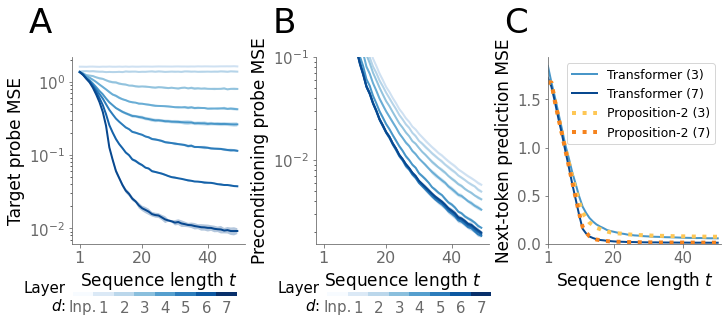

In [30]:
legend_fontsize = 'small'

def subplot_probe(ax,
                  cols: List,
                  mean: List,
                  std: List,
                  name: str,
                  num_graphs: int):
    for i in range(num_graphs):
        c = cols[i]
        linestyle = 'solid'
        ax.plot(jnp.array(mean)[:,i], linewidth=2, color=c, linestyle=linestyle, label=f'$d={i}$')
        ax.fill_between(range(mean.shape[0]), (mean[:,i]-std[:,i]),(mean[:,i]+std[:,i]) ,alpha=0.3, facecolor=c)
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel(name)
    ax.set_yscale('log')
    ax.set_xticks([0,19,39],[1,20,40],fontsize=16)

def subplot_perf(ax,
                 seq_loss_dict: Dict[str, any],
                 model_list: List[str],
                 cols: List,
                 line_scale: int = 1):
    loss_list = seq_loss_dict['losses']
    loss_arr = jnp.array(loss_list)
    mean_losses = tuple([jnp.mean(loss_arr[idx],axis=0) for idx in range(len(model_list))])
    std_losses = tuple([jnp.std(loss_arr[idx],axis=0) for idx in range(len(model_list))])
    for idx in range(len(model_list)):
        ax.plot(mean_losses[idx], linewidth=2*(2 if model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] else 1), linestyle='dotted' if model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] else 'solid', label=model_list[idx], color=cols[idx])
        ax.fill_between(range(len(mean_losses[0])),
                        (mean_losses[idx] - std_losses[idx]),
                        (mean_losses[idx] - std_losses[idx]),
                        alpha=0.3,
                        facecolor=cols[idx])
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel('Next-token prediction MSE')
    ax.set_xlim(0,50)
    ax.set_ylim(0,)
    ax.legend(loc=1, fontsize=legend_fontsize)
    ax.set_xticks([0,19,39],[1,20,40])

def plot_probing(result_dict_probe: Dict[str, any],
                 seq_loss_dict_one: Dict[str, any],
                 model_list: List):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    # Extract Probe info:
    results_prob = result_dict_probe['results']
    _, next_probes, inv_curr_probes, _, _ = tuple([jnp.array(res) for res in results_prob])
    mean_next_probes = jnp.mean(next_probes, axis=0)[1:,:]
    std_next_probes = jnp.std(next_probes, axis=0)[1:,:]
    mean_inv_curr_probes = jnp.mean(inv_curr_probes, axis=0)[1:,:]
    std_inv_curr_probes = jnp.std(inv_curr_probes, axis=0)[1:,:]


    num_graphs = len(mean_next_probes[1])
    colormap_sm, colormap_mesa, colormap_lin = tuple([plt.get_cmap(col, 100) for col in ['Blues', 'Reds', 'Greens']])
    subplot_col_fn = lambda colmap : [colmap(i) for i in [10+(80//num_graphs)*(k+1) for k in range(num_graphs)]]

    c_tf3 = subplot_col_fn(colormap_sm)[-4]
    c_tf7 = subplot_col_fn(colormap_sm)[-1]
    c_lsq3 = plt.get_cmap('YlOrBr', 100)(36)
    c_lsq7 = plt.get_cmap('YlOrBr', 100)(56)

    cols_p1 = [c_tf3, c_tf7, c_lsq3, c_lsq7]

    fig, axs = plt.subplots(nrows=1,
                            ncols=3,
                            figsize=(10, 4),
                            gridspec_kw={'width_ratios': [1,1,1]},
                            layout='constrained')

    ################################################
    # Probe Targets:
    subplot_probe(ax=axs[0],
                  cols=subplot_col_fn(colormap_sm),
                  mean=mean_next_probes,
                  std=std_next_probes,
                  name='Target probe MSE',
                  num_graphs = num_graphs)

    # Corresponding Colorbar:
    box = axs[0].get_position()
    cbar_height = 0.015
    space_between = 0.0
    cbar_offset = 0.13
    cbar_ax1 = fig.add_axes([box.x0-0.03, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_lin
    bounds = [1,2,3,4,5,6,7,8,9]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_sm),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["Inp.", "$1$", "$2$", "$3$", "$4$", "$5$", "$6$", "$7$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0-0.04, label_y_position+0.005, 'Layer\n$d$:', va='center', ha='right', rotation='horizontal')
    ################################################
    # Probe Inverse:
    subplot_probe(ax=axs[1],
                  cols=subplot_col_fn(colormap_sm),
                  mean=mean_inv_curr_probes,
                  std=std_inv_curr_probes,
                  name='Preconditioning probe MSE',
                  num_graphs = num_graphs)
    axs[1].set_ylim(0.00153,0.1)
    # Corresponding Colorbar:
    box = axs[1].get_position()
    cbar_height = 0.015
    space_between = 0.0
    cbar_offset = 0.13
    cbar_ax1 = fig.add_axes([box.x0+0.05, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_lin
    bounds = [1,2,3,4,5,6,7,8,9]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_sm),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["Inp.", "$1$", "$2$", "$3$", "$4$", "$5$", "$6$", "$7$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.04, label_y_position+0.005, 'Layer\n$d$:', va='center', ha='right', rotation='horizontal')


    ################################################
    # Performance - Analyses:
    subplot_perf(ax=axs[2],
                 seq_loss_dict=seq_loss_dict_one,
                 model_list=model_list,
                 cols=cols_p1,
                 line_scale=2)

    ################################################

    label_size = 34
    axs[0].text(-0.25, 1.27, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.25, 1.27, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')
    axs[2].text(-0.25, 1.27, 'C', transform=axs[2].transAxes, fontsize=label_size, va='top')

    if store_results:
        fig.savefig('fully_full_probing.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_probing(result_dict_probe = result_dict_fully,
             seq_loss_dict_one = seq_loss_dict_fully,
             model_list = ['Transformer (3)', 'Transformer (7)', 'Proposition-2 (3)', 'Proposition-2 (7)'])